# Normalized Autoencoders

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from models.modules import FCNet, IsotropicGaussian, FCResNet
from models.ae import AE, VAE
from models.nae import NAE, FFEBM
from models.bnaf import BNAF
from models.mmd import mmd

from loader.synthetic import sample2d
from IPython.display import clear_output


In [2]:
device = 'cuda:1'

In [3]:
dset = '8gaussians'
if dset == '8gaussians':
    xmin, xmax, ymin, ymax = [-4, 4, -4, 4]
elif dset == '2spirals':
    xmin, xmax, ymin, ymax = [-4, 4, -4, 4]
elif dset == 'checkerboard':
    xmin, xmax, ymin, ymax = [-4, 4, -4, 4]
batch_size = 200

In [4]:
XX, YY = torch.meshgrid(torch.linspace(xmin, xmax, 100), torch.linspace(ymin,ymax, 100))
grid = torch.cat([XX.reshape(-1,1), YY.reshape(-1,1)], dim=1)
grid_gpu = grid.to(device)

# On-Manifold Initialization

In [5]:
zdim = 2
encoder = FCResNet(2, zdim, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
decoder = FCResNet(zdim, 2, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
nae = NAE(encoder, decoder, sampling='on_manifold',
           x_step=30, x_stepsize=None, x_noise_std=0.1, x_bound=(-5, 5), x_clip_langevin_grad=None,
           z_step=10, z_stepsize=None, z_noise_std=0.1, z_bound=None, z_clip_langevin_grad=None,
           gamma=1, delta=0., spherical=True,
           sigma=0.5, sigma_trainable=True,
           temperature=0.5, temperature_trainable=True,
           l2_norm_reg=None, l2_norm_reg_en=None, z_norm_reg=None,
           initial_dist='gaussian', replay=True, replay_ratio=0.95, buffer_size=10000,
           deterministic=True, mh=True, mh_z=False, reject_boundary=True, reject_boundary_z=True)

nae.to(device)

opt = Adam([{'params': list(nae.encoder.parameters()) + list(nae.decoder.net.parameters())},
            {'params': nae.temperature_, 'lr': 1e-3},
            {'params': nae.decoder.sigma}], lr=1e-5)
l_loss = []
l_mmd = []
l_en_norm = []
l_T = []
l_sigma = []
l_temperature = []
l_pos = []; l_neg = []

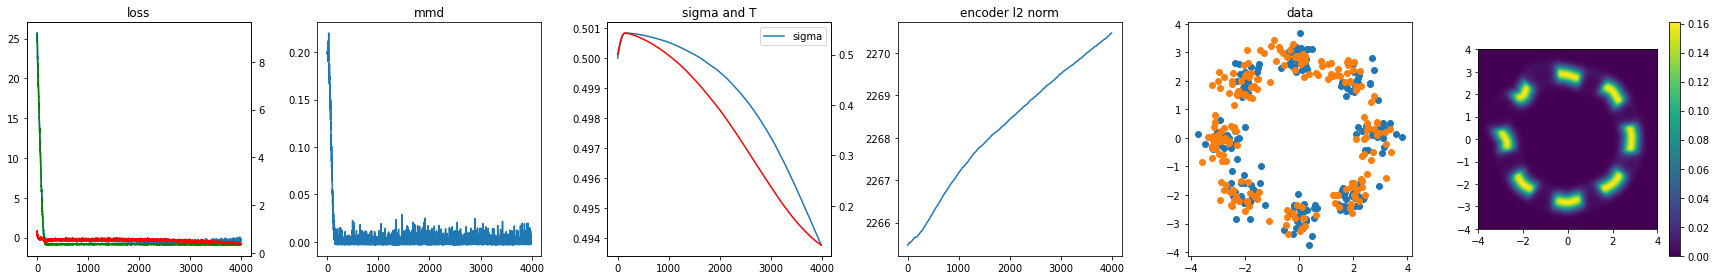

In [7]:
n_iter = 2000
for i_iter in tqdm(range(n_iter)):
    batch_x = sample2d(dset, batch_size=batch_size)
    batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
    d_train = nae.train_step(batch_x, opt)
    l_loss.append(d_train['loss'])
    l_pos.append(d_train['pos_e']); l_neg.append(d_train['neg_e'])
    l_en_norm.append(d_train['encoder_norm'])
    l_sigma.append(nae.decoder.sigma.item())
    l_temperature.append(nae.temperature.item())
    
    mmd_ = mmd(batch_x, d_train['x_neg'].to(device)).item()
    l_mmd.append(mmd_)
    
    if i_iter % 10 == 0:
        batch_x = batch_x.cpu()
        sample_x = d_train['x_neg'] 
        
        clear_output(wait=True)
        fig, axs = plt.subplots(ncols=6, figsize=(24,4))
        axs[0].plot(l_loss); axs[0].set_title('loss')
        ax2 = axs[0].twinx()
        ax2.plot(l_pos, 'g', label='pos_e')
        ax2.plot(l_neg, 'r', label='neg_e')
        axs[1].plot(l_mmd); axs[1].set_title('mmd')
        axs[2].plot(l_sigma, label='sigma'); axs[2].set_title('sigma and T'); 
        ax2 = axs[2].twinx()
        ax2.plot(l_temperature, label='T', c='r'); axs[2].legend()
        axs[3].plot(l_en_norm); axs[3].set_title('encoder l2 norm')
        axs[4].scatter(batch_x[:,0], batch_x[:,1]); axs[4].set_title('data')
        axs[4].scatter(sample_x[:,0], sample_x[:,1])
        E = nae.energy_T(grid_gpu).detach().cpu().reshape(100, 100)
        Omega = ((8 / 100 * 8 / 100) * np.exp(-E)).sum()
        img = axs[5].imshow(np.exp(-E.T)/Omega, origin='lower', extent=(-4, 4, -4, 4))
        fig.colorbar(img, ax=axs[5])
        plt.tight_layout()
        plt.show()
        
torch.save(nae.state_dict(), f'nae_{zdim}_{dset}.pth')

In [30]:
zdim = 3
encoder = FCResNet(2, zdim, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
decoder = FCResNet(zdim, 2, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
nae = NAE(encoder, decoder, sampling='on_manifold',
           x_step=30, x_stepsize=None, x_noise_std=0.1, x_bound=(-5, 5), x_clip_langevin_grad=None,
           z_step=10, z_stepsize=None, z_noise_std=0.2, z_bound=None, z_clip_langevin_grad=None,
           gamma=1, delta=0., spherical=False,
           sigma=1, sigma_trainable=False,
           temperature=0.1, temperature_trainable=True,
           l2_norm_reg=None, l2_norm_reg_en=None, z_norm_reg=0.01,
           initial_dist='gaussian', replay=True, replay_ratio=0.95, buffer_size=10000,
           deterministic=True, mh=True, mh_z=False, reject_boundary=True, reject_boundary_z=True)

nae.to(device)

opt = Adam([{'params': list(nae.encoder.parameters()) + list(nae.decoder.net.parameters())},
            {'params': nae.temperature_, 'lr': 1e-3},
            {'params': nae.decoder.sigma}], lr=1e-5)
l_loss = []
l_mmd = []
l_en_norm = []
l_T = []
l_sigma = []
l_temperature = []
l_pos = []; l_neg = []

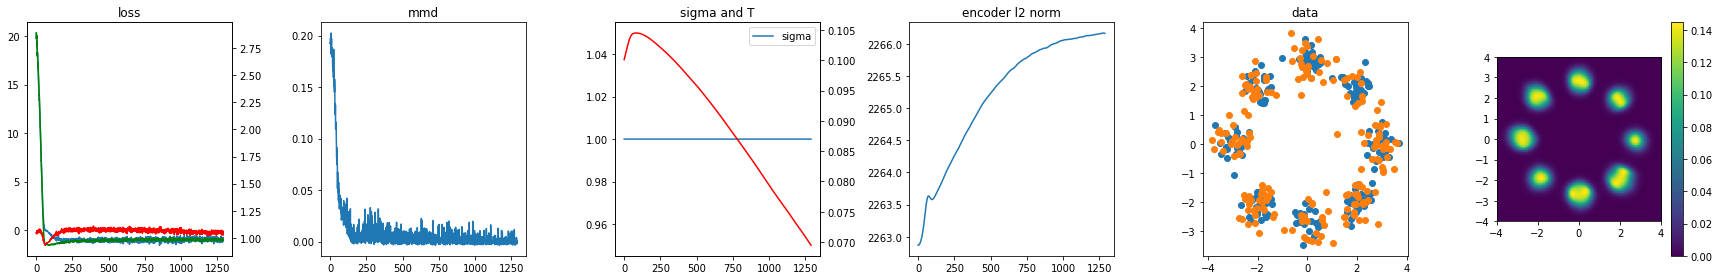

KeyboardInterrupt: 

In [31]:
n_iter = 2000
for i_iter in tqdm(range(n_iter)):
    batch_x = sample2d(dset, batch_size=batch_size)
    batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
    d_train = nae.train_step(batch_x, opt)
    l_loss.append(d_train['loss'])
    l_pos.append(d_train['pos_e']); l_neg.append(d_train['neg_e'])
    l_en_norm.append(d_train['encoder_norm'])
    l_sigma.append(nae.decoder.sigma.item())
    l_temperature.append(nae.temperature.item())
    
    mmd_ = mmd(batch_x, d_train['x_neg'].to(device)).item()
    l_mmd.append(mmd_)
    
    if i_iter % 10 == 0:
        batch_x = batch_x.cpu()
        sample_x = d_train['x_neg'] 
        
        clear_output(wait=True)
        fig, axs = plt.subplots(ncols=6, figsize=(24,4))
        axs[0].plot(l_loss); axs[0].set_title('loss')
        ax2 = axs[0].twinx()
        ax2.plot(l_pos, 'g', label='pos_e')
        ax2.plot(l_neg, 'r', label='neg_e')
        axs[1].plot(l_mmd); axs[1].set_title('mmd')
        axs[2].plot(l_sigma, label='sigma'); axs[2].set_title('sigma and T'); 
        ax2 = axs[2].twinx()
        ax2.plot(l_temperature, label='T', c='r'); axs[2].legend()
        axs[3].plot(l_en_norm); axs[3].set_title('encoder l2 norm')
        axs[4].scatter(batch_x[:,0], batch_x[:,1]); axs[4].set_title('data')
        axs[4].scatter(sample_x[:,0], sample_x[:,1])
        E = nae.energy_T(grid_gpu).detach().cpu().reshape(100, 100)
        Omega = ((8 / 100 * 8 / 100) * np.exp(-E)).sum()
        img = axs[5].imshow(np.exp(-E.T)/Omega, origin='lower', extent=(-4, 4, -4, 4))
        fig.colorbar(img, ax=axs[5])
        plt.tight_layout()
        plt.show()
        
torch.save(nae.state_dict(), f'nae_{zdim}_{dset}.pth')

In [32]:
torch.save(nae.state_dict(), f'nae_{zdim}_{dset}.pth')

In [22]:
d_sample = nae.sample(batch_x[:].to(device), replay=True)

In [23]:
sample_x0 = d_sample['sample_x0'].detach().cpu()
sample_x = d_sample['sample_x'].detach().cpu()

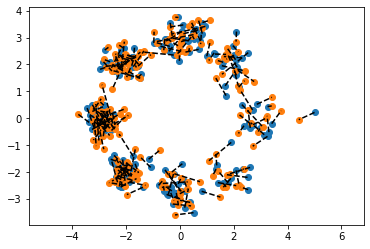

In [24]:
plt.scatter(sample_x0[:,0], sample_x0[:,1])
plt.scatter(sample_x[:,0], sample_x[:,1])
plt.plot(np.stack([sample_x0[:,0], sample_x[:,0]]), np.stack([sample_x0[:,1], sample_x[:,1]]), 'k--' );
plt.axis('equal');

In [25]:
z0 = d_sample['sample_z0']
z = d_sample['sample_z']

In [26]:
from_z0 = nae.decoder.sample(z0).detach().cpu()
from_z = nae.decoder.sample(z).detach().cpu()

(-4.129013013839722, 5.76429934501648, -4.636667263507843, 4.146351110935211)

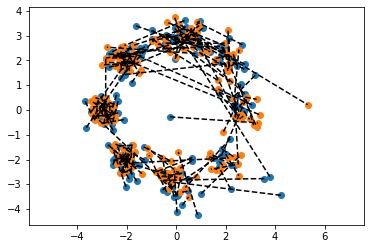

In [27]:
plt.scatter(from_z0[:,0], from_z0[:,1])
plt.scatter(from_z[:,0], from_z[:,1])
plt.plot(np.stack([from_z0[:,0], from_z[:,0]]), np.stack([from_z0[:,1], from_z[:,1]]), 'k--' );
plt.axis('equal')